**Katie Chen <br>
INFO 370 <br>
2/17/2019**

# Modeling Dengue
## Problem Overview
Dengue fever is a mosquito-borne disease that is caused by dengue 1-4 viruses. It is transmitted between humans by the bite of mosquitos, primarily by female *Aedes aegypti*. When the mosquito bites the person who is infected with Dengue virus, it becomes infected and can transmit the virus to healthy people by biting them. In most cases, dengue virus cannot be spread directly from one person to another. The symptoms of dengue fever includes fever, headache, vomiting, joint, bone or muscle pains, and skin rash ([Wikepedia](https://en.wikipedia.org/wiki/Dengue_fever)). 

Dengue is spread throughout tropical and subtropical regions where *Aedes aegypti* mosquitos dwell, typically in Southeast Asia, Africa, the Americas, and Western Pacific regions. Here is a map from *World Health Organization* that shows the distribution of dengue worldwide in 2016 ([WHO](https://www.who.int/denguecontrol/epidemiology/en/)).
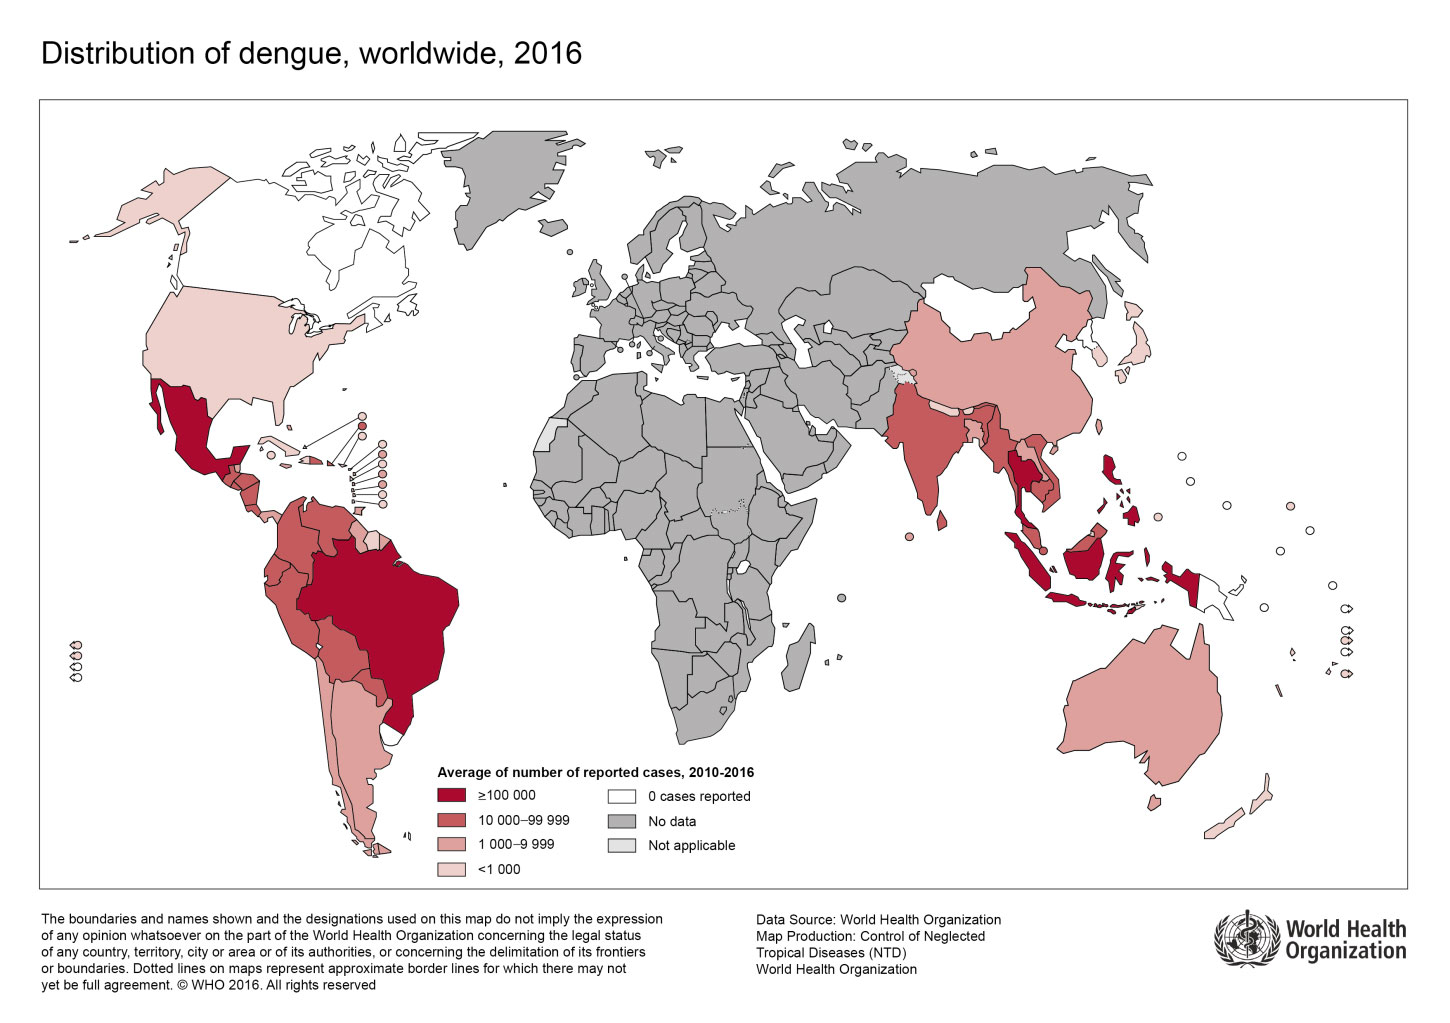

*Aedes aegypti* mosquitos lay their eggs in the containers that fill with water, so their population is high during the rainy seasons. Their habitation requires a warmer temperature, and thus they cannot survive in cold winters which the temperature is below 10&deg;C ([Nature](https://www.nature.com/scitable/topicpage/dengue-transmission-22399758)). Therefore, **temperature**, **humidity** and **rainfall** are important factors for the transmission of dengue. We also believe that the **vegetation level** is important because more vegetation means more rainfall in the area. 

The dataset from [DengAI: Predicting Disease Spread Dataset](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/) provides us pertinent climate variables, which we will take a close look in the data analysis. The variables are in the following:

**Temperature:**
-  `station_max_temp_c` - Maximum temperature
-  `station_min_temp_c` - Minimum temperature
-  `station_avg_temp_c` – Average temperature
-  `station_diur_temp_rng_c` – Diurnal temperature range
-  `reanalysis_dew_point_temp_k` – Mean dew point temperature
-  `reanalysis_air_temp_k` – Mean air temperature
-  `reanalysis_max_air_temp_k` – Maximum air temperature
-  `reanalysis_min_air_temp_k` – Minimum air temperature
-  `reanalysis_avg_temp_k` – Average air temperature
-  `reanalysis_tdtr_k` – Diurnal temperature range

**Precipitation:**
-  `station_precip_mm` – Total precipitation
-  `precipitation_amt_mm` – Total precipitation
-  `reanalysis_sat_precip_amt_mm` – Total precipitation
-  `reanalysis_precip_amt_kg_per_m2` – Total precipitation

**Humidity:**
-  `reanalysis_relative_humidity_percent` – Mean relative humidity
-  `reanalysis_specific_humidity_g_per_kg` – Mean specific humidity

**Normalized difference vegetation index:**
-  `ndvi_se` – Pixel southeast of city centroid
-  `ndvi_sw` – Pixel southwest of city centroid
-  `ndvi_ne` – Pixel northeast of city centroid
-  `ndvi_nw` – Pixel northwest of city centroid

Through this report, we will examine the relationship between these variables and the number of dengue cases.

In [5]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

# read two csv files
dengue_data = pd.read_csv('data/dengue_features_train.csv')
dengue_cases = pd.read_csv('data/dengue_labels_train.csv')

# combine two dataframes
dengue_data['dengue_cases'] = dengue_cases['total_cases']

# create a new variable to correct weekofyear
dengue_data.insert(0, 'new_weekofyear', dengue_data['weekofyear'])

# divide data into two dataframes, each with one city
sj = dengue_data[dengue_data['city'] == 'sj']
iq = dengue_data[dengue_data['city'] == 'iq']

# adjust the weekofyear to start from 1 for each year for sj and iq dataset
for i in range(1993, 2007):
    sj.loc[sj.year == i, 'new_weekofyear'] = list(range(1,53))
iq.loc[iq.year == 2000, 'new_weekofyear'] += 1
iq.loc[iq.year == 2010, 'new_weekofyear'] = list(range(1, iq[iq['year'] == 2010].shape[0]+1))
for i in range(2005, 2007):
    iq.loc[iq.year == i, 'new_weekofyear'] = list(range(1,53))

## Data Preparation
This dataset lists out dengue cases in San Juan and Iquitos. The attributes include temperature, precipitation, humidity, vegetation, year, weeek of year and number of dengue cases in each week. 

We found out that `weekofyear` variable is inconsistent for each year. In most cases, each year has 52 weeks, however, some have week of 53 and the 53rd week is in next year. In order to make the data easier to manipulate, we created a new variable `new_weekofyear` to correct the number of weeks for each year.

This dataset has missing values, and we need to handle them either by removing them or replacing them with values. First, we took a look of the number of null values in each city.

**Number of missing values in San Juan dataset**

In [6]:
sj.isnull().sum()

new_weekofyear                             0
city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_ma

**Number of missing values in Iquitos dataset**

In [7]:
iq.isnull().sum()

new_weekofyear                            0
city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c              

We saw that in San Juan dataset, the worst offending column is `ndvi_ne`, which has 191 null values. Therefore, we decided to drop this column in San Juan dataset because replacing a big chunk of null values would lower the accuracy of the model. 

With other missing values, we decided to replace them with the average of columns. However, each month has different temperature and precipitation. For example, in the summer, the temperature and precipitation will increase in tropical regions. In the winter, the temperature and precipitation will decrease. Inspired by [Brian Connor's project](https://towardsdatascience.com/dengue-fever-and-how-to-predict-it-a32eab1dbb18), we replaced the null values with the average of columns for the same week. It is reasonable that the pattern in each week is similar for every year.

There are two average temperatue variables measured by NOAA's GHCN station measurements and NOAA's NCEP reanalysis measurements. Since they are close, we created a new variable `avg_temp_c` which is the average of `station_avg_temp_c` and `reanalysis_avg_temp_k`. We would use this variable later to perform temperature analysis.

In [41]:
# drop 'ndvi_ne' column from sj dataset and replace others with the average of columns for
# the same week
new_sj = sj.drop('ndvi_ne', axis = 1)
for i in list(new_sj)[5:]:
    new_sj[i].fillna(new_sj.groupby('new_weekofyear')[i].transform('mean'), inplace=True)

# replace null values in iq dataset with the average of columns for the same week
for i in list(iq)[5:]:
    iq[i].fillna(iq.groupby('new_weekofyear')[i].transform('mean'), inplace=True)
    
# create the new avg temp for sj and iq dataset
new_sj['avg_temp_c'] = (new_sj['reanalysis_avg_temp_k'] - 273.15 + new_sj['station_avg_temp_c']) / 2
iq['avg_temp_c'] = (iq['reanalysis_avg_temp_k'] - 273.15 + iq['station_avg_temp_c']) / 2
new_sj[(new_sj.new_weekofyear == 28) & (new_sj.year == 1991)]

,new_weekofyear,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,dengue_cases,avg_temp_c
62,28,sj,1991,28,1991-07-09,0.114282,0.13805,0.167917,6.13,300.001429,...,6.13,17.151429,2.428571,28.414286,6.671429,32.8,24.4,4.6,14,27.717857


## Exploratory Data Analysis
We were interested in the pattern of number of dengue fever cases over time. Next we explored the pattern of dengue fever cases for San Juan and Iquitos.

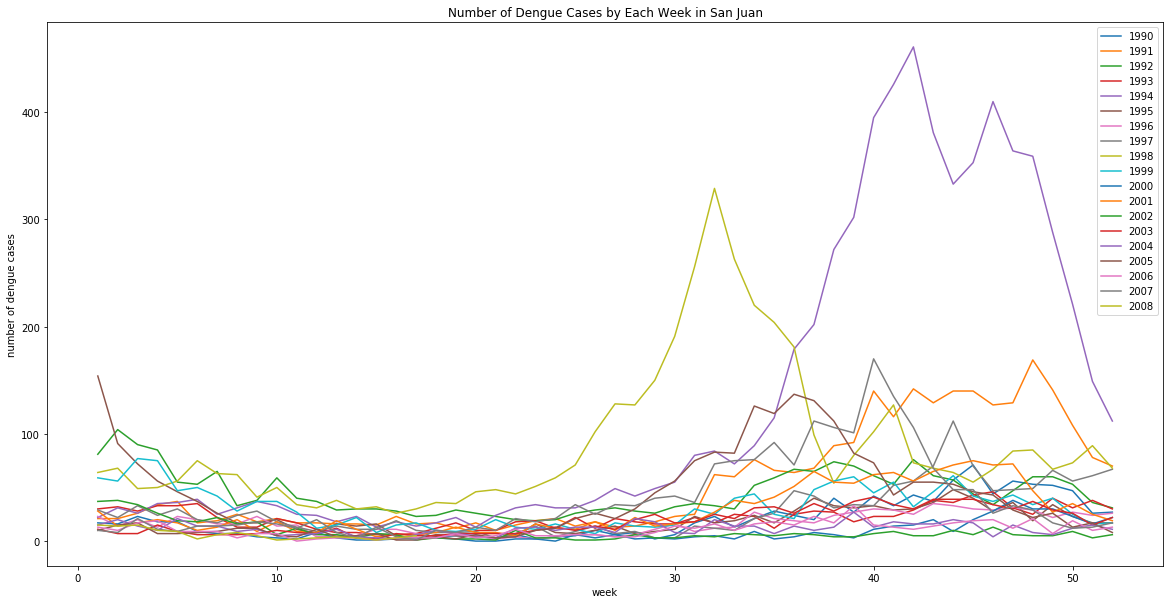

In [9]:
# plot the number of dengue cases by each week for year 1990 - 2008 in San Juan
plt.figure(figsize=(20,10))
for k, g in new_sj.groupby('year'):
    plt.plot(g['new_weekofyear'], g['dengue_cases'], label = k)
plt.title('Number of Dengue Cases by Each Week in San Juan')
plt.xlabel('week')
plt.ylabel('number of dengue cases')
plt.legend()
plt.show()

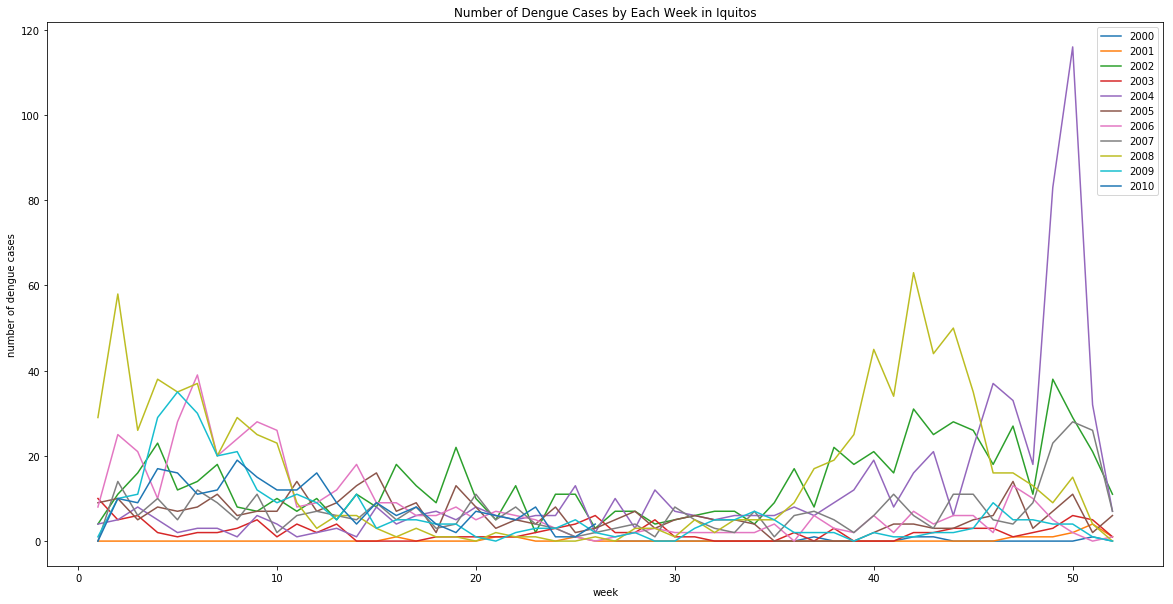

In [10]:
# plot the number of dengue cases by each week for year 2000 - 2010 in Iquitos
plt.figure(figsize=(20,10))
for k, g in iq.groupby('year'):
    plt.plot(g['new_weekofyear'], g['dengue_cases'], label = k)
plt.title('Number of Dengue Cases by Each Week in Iquitos')
plt.xlabel('week')
plt.ylabel('number of dengue cases')
plt.legend()
plt.show()

From the first plot we saw that in San Juan, the number of dengue cases **decreases from November to April**, and **increases from May to October**. In particular, the number of dengue cases is really high from September to December in year 1994, and the number of dengue cases is also high from June to September in 1998.

The number of dengue cases in Iquitos has similar pattern, but it has more variability. From the plot, we saw that it has a sharp increase at the first week, then decreases until the 27th week. After that, it has a **increase from July to October**. There is a sharp increase happens in December 2004, which is unusual compared to other years. Overall, these two plots show that **the outbreak of dengue fever happens between July and October when this time period is associated with higher temeprature and more precipitation**.

Next we explored how the number of dengue cases change over time.

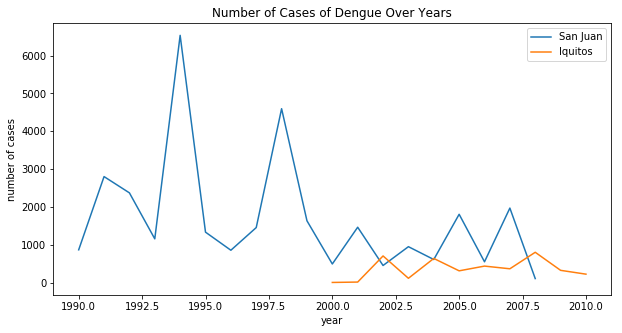

In [11]:
# plot the number of cases of dengue over years in San Juan and Iquitos
plt.figure(figsize=(10,5))
y_sj = new_sj.groupby('year').sum()['dengue_cases']
x_sj = new_sj.year.unique()
plt.plot(x_sj, y_sj, label = 'San Juan')

y_iq = iq.groupby('year').sum()['dengue_cases']
x_iq = iq.year.unique()
plt.plot(x_iq, y_iq, label = 'Iquitos')
plt.title('Number of Cases of Dengue Over Years')
plt.xlabel('year')
plt.ylabel('number of cases')
plt.legend()
plt.show()

In San Juan, the number of dengue cases is a lot higher before 2000. **It decreases by one third after 2000**. The Iquitos dataset does not contain data that is before 2000. **It shows similar pattern of the number of dengue cases as San Juan after 2000**, however the number is lower than the number in San Juan. We assume that after 2000, the sanitation level has improved, and more vaccines have been produced to reduce the number of dengue fever.

Since the measurement of temperature is the most stable variable in the dataset, we made a plot to show how temperature affects the number of dengue cases in San Juan and Iquitos.

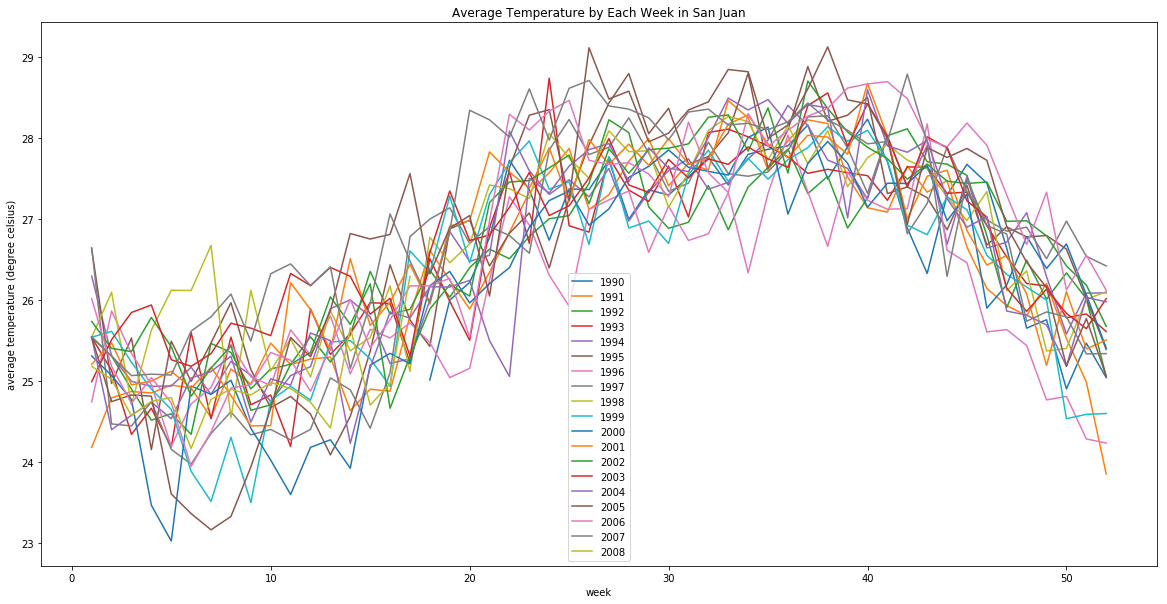

In [12]:
# plot the average temperature by each week for year 1990 - 2008 in San Juan
plt.figure(figsize=(20,10))
for k, g in new_sj.groupby('year'):
    plt.plot(g['new_weekofyear'], g['avg_temp_c'], label = k)
plt.title('Average Temperature by Each Week in San Juan')
plt.xlabel('week')
plt.ylabel('average temperature (degree celsius)')
plt.legend()
plt.show()

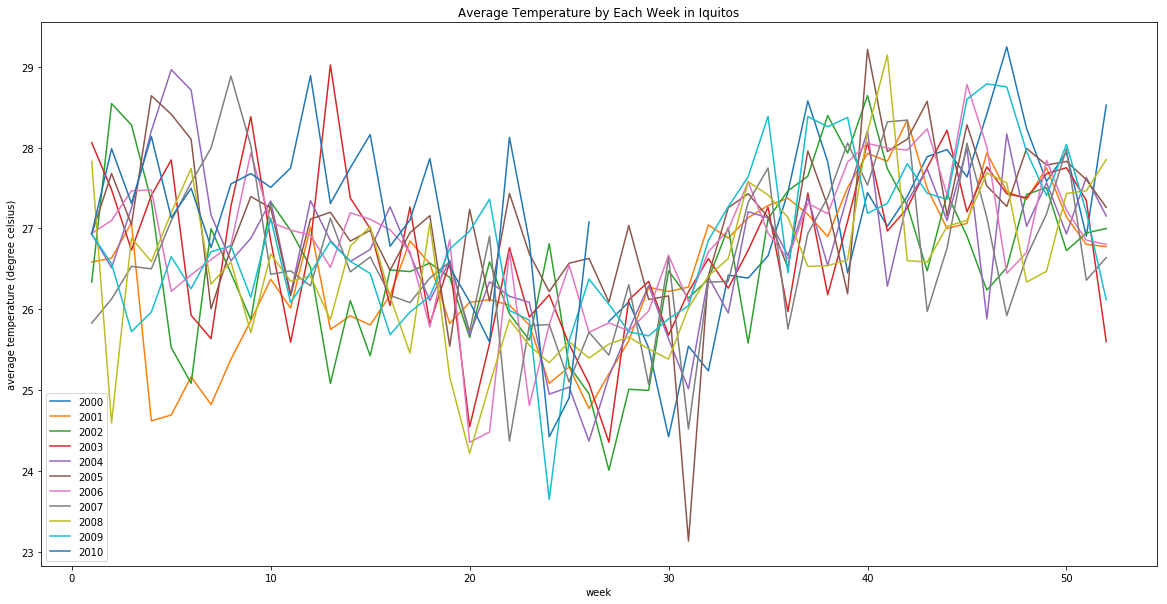

In [13]:
# plot the average temperature by each week for year 2000 - 2010 in Iquitos
plt.figure(figsize=(20,10))
for k, g in iq.groupby('year'):
    plt.plot(g['new_weekofyear'], g['avg_temp_c'], label = k)
plt.title('Average Temperature by Each Week in Iquitos')
plt.xlabel('week')
plt.ylabel('average temperature (degree celsius)')
plt.legend()
plt.show()

These two plots show how temperature changes in each week in San Juan and Iquitos. We saw that the pattern of the temperature matches the pattern of dengue cases for both cities. When the temperature increases, the number of dengue cases increase. The number of dengue cases decreases as the temperature decreases. Therefore, **temperature has positive relationship with the number of dengue cases**.

We wanted to know which variables are most correlated with the number of dengue cases, thus we presented the relationship between each variable and the number of total cases by calculating the correlation.

For San Juan dataset, the top 9 climate variables that are most correlated with the number of dengue cases are:

In [14]:
# calculate the correlation of each variable in San Juan dataset and select the top 9
copy_sj = new_sj
corr_sj = copy_sj.drop(['new_weekofyear', 'city', 'year', 'weekofyear', 'week_start_date'], axis = 1).corr().loc['dengue_cases', :]
corr_sj.abs().nlargest(10)[1:]

reanalysis_specific_humidity_g_per_kg    0.206849
reanalysis_dew_point_temp_k              0.202746
station_avg_temp_c                       0.194848
reanalysis_max_air_temp_k                0.193268
avg_temp_c                               0.191141
station_max_temp_c                       0.188246
reanalysis_min_air_temp_k                0.186690
reanalysis_air_temp_k                    0.180879
station_min_temp_c                       0.175336
Name: dengue_cases, dtype: float64

For Iquitos dataset, the top 9 climate variables that are most correlated with the number of dengue cases are:

In [15]:
# calculate the correlation of each variable in Iquitos dataset and select the top 9
copy_iq = iq
corr_iq = copy_iq.drop(['new_weekofyear', 'city', 'year', 'weekofyear', 'week_start_date'], axis = 1).corr().loc['dengue_cases', :]
corr_iq.abs().nlargest(10)[1:]

reanalysis_specific_humidity_g_per_kg    0.234641
reanalysis_dew_point_temp_k              0.228573
reanalysis_min_air_temp_k                0.213076
station_min_temp_c                       0.200275
reanalysis_tdtr_k                        0.133302
reanalysis_relative_humidity_percent     0.129279
station_avg_temp_c                       0.128810
avg_temp_c                               0.111506
reanalysis_precip_amt_kg_per_m2          0.099219
Name: dengue_cases, dtype: float64

We observed that for both San Juan and Iquitos dataset, **humidity** and **mean of dew point temerpature** are most correlated with the number of dengue cases.

## Statistical Modeling
Since our outcome of interest is the number of dengue cases and it is a count variable, we decided to use Poisson regression or Negative Binomial regression. First of all, we need to look at the mean and variance of `dengue_cases` to decide which one to use.

The summary statistics for `dengue_cases` is the following:

In [16]:
new_sj.describe()['dengue_cases']

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: dengue_cases, dtype: float64

We saw that the standard deviation is 51, which means the variance is a lot higher than mean. This shows that the number of dengue cases is over-dispersed. Therefore, we decided to use **Negative Binomial regression** to model the data as it is more flexible in this situation compared to Poisson regression.

Negative Binomial regression is a generalization of Poisson regression, and so it is used for count variable. The differnece between Negative Binomial regression and Poisson regression is that Negative Binomial regression is better for over-dispersed data, which the mean of outcome variable is lower than the variance.

In Problem Overview, we predicted that **temperature**, **humidity**, **rainfall** and **vegetation level** are important factors for the transmission of dengue. It is because Aedes aegypti mosquitos lay their eggs in the containers that fill with water, so their population is high during the rainy seasons. Their habitation requires a warmer temperature, and thus they cannot survive in cold winters which the temperature is below 10°C. We also assume that more vegetation means more rainfall in the area. Next we would build statistical model for San Juan and Iquitos dataset.

### San Juan Model
In Data Analysis, we found out the top 9 climate variables that are most correlated with the number of dengue cases are:

In [17]:
corr_sj.abs().nlargest(10)[1:]

reanalysis_specific_humidity_g_per_kg    0.206849
reanalysis_dew_point_temp_k              0.202746
station_avg_temp_c                       0.194848
reanalysis_max_air_temp_k                0.193268
avg_temp_c                               0.191141
station_max_temp_c                       0.188246
reanalysis_min_air_temp_k                0.186690
reanalysis_air_temp_k                    0.180879
station_min_temp_c                       0.175336
Name: dengue_cases, dtype: float64

In [18]:
# Negative Binomial regression with forward selection
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg'
univariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
univariate_model.summary()
new_sj["pred"] = univariate_model.predict()

In [19]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [20]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c '
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [21]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [22]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k + avg_temp_c'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [23]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k + avg_temp_c + station_max_temp_c'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [24]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k + avg_temp_c + station_max_temp_c + reanalysis_min_air_temp_k'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

In [25]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k + avg_temp_c + station_max_temp_c + reanalysis_min_air_temp_k + reanalysis_air_temp_k + station_min_temp_c'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()

By doing Forward Selection, we found that the model with `reanalysis_specific_humidity_g_per_kg`, `reanalysis_dew_point_temp_k`, `station_avg_temp_c`, `reanalysis_max_air_temp_k`, `avg_temp_c`, `station_max_temp_c`, `reanalysis_min_air_temp_k`, `reanalysis_air_temp_k` is the best among these nine models. The regression summary is:

In [26]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c + reanalysis_max_air_temp_k + avg_temp_c + station_max_temp_c + reanalysis_min_air_temp_k + reanalysis_air_temp_k'
multivariate_model = smf.glm(formula = formula, data = new_sj, family = sm.families.NegativeBinomial()).fit()
new_sj["pred"] = multivariate_model.predict()
sj_coef = multivariate_model.params
multivariate_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           dengue_cases   No. Observations:                  936
Model:                            GLM   Df Residuals:                      927
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4186.1
Date:                Sat, 02 Mar 2019   Deviance:                       966.36
Time:                        15:11:27   Pearson chi2:                 1.50e+03
No. Iterations:                    10   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              -208.8194    181.570     -1.150      0.250    -564.690     147.052
reanalysis_specific_humidity_g_per_kg     0.9898      0.424      2.333      0.020       0.158       1.821
reanalysis_dew_point_temp_k              -0.8387      0.418     -2.008      0.045      -1.657      -0.020
station_avg_temp_c                        1.5557      0.433      3.595      0.000       0.708       2.404
reanalysis_max_air_temp_k                 0.1912      0.100      1.915      0.055      -0.004       0.387
avg_temp_c                               -3.2313      0.853     -3.788      0.000      -4.903      -1.559
station_max_temp_c                        0.1121      0.046      2.457      0.014       0.023       0.202
reanalysis_min_air_temp_k                 0.3061      0.095      3.224      0.001       0.120       0.492
reanalysis_air_temp_k                     1.1200      0.421      2.661      0.008       0.295       1.945
=========================================================================================================
"""

### Iquitos Model
In Data Analysis, we found out the top 9 climate variables that are most correlated with the number of dengue cases are:

In [27]:
corr_iq.abs().nlargest(10)[1:]

reanalysis_specific_humidity_g_per_kg    0.234641
reanalysis_dew_point_temp_k              0.228573
reanalysis_min_air_temp_k                0.213076
station_min_temp_c                       0.200275
reanalysis_tdtr_k                        0.133302
reanalysis_relative_humidity_percent     0.129279
station_avg_temp_c                       0.128810
avg_temp_c                               0.111506
reanalysis_precip_amt_kg_per_m2          0.099219
Name: dengue_cases, dtype: float64

In [28]:
# Negative Binomial regression with Forward Selection
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg'
univariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
univariate_model.summary()
iq["pred"] = univariate_model.predict()

In [29]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [30]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [31]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [32]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_tdtr_k'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [33]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_tdtr_k + reanalysis_relative_humidity_percent'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [34]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_tdtr_k + reanalysis_relative_humidity_percent + station_avg_temp_c + avg_temp_c'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

In [35]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_tdtr_k + reanalysis_relative_humidity_percent + station_avg_temp_c + avg_temp_c + reanalysis_precip_amt_kg_per_m2'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()

By doing Forward Selection, we found that the model with `reanalysis_specific_humidity_g_per_kg`, `reanalysis_dew_point_temp_k`, `reanalysis_min_air_temp_k`, `station_min_temp_c`, `reanalysis_tdtr_k`, `reanalysis_relative_humidity_percent`, `station_avg_temp_c` is the best among these nine models. The regression summary is:

In [36]:
formula = 'dengue_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + reanalysis_min_air_temp_k + station_min_temp_c + reanalysis_tdtr_k + reanalysis_relative_humidity_percent + station_avg_temp_c'
multivariate_model = smf.glm(formula = formula, data = iq, family = sm.families.NegativeBinomial()).fit()
multivariate_model.summary()
iq["pred"] = multivariate_model.predict()
iq_coef = multivariate_model.params
multivariate_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           dengue_cases   No. Observations:                  520
Model:                            GLM   Df Residuals:                      512
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1562.7
Date:                Sat, 02 Mar 2019   Deviance:                       702.19
Time:                        15:11:27   Pearson chi2:                     776.
No. Iterations:                     9   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               361.2546    166.619      2.168      0.030      34.688     687.821
reanalysis_specific_humidity_g_per_kg     1.5508      0.560      2.767      0.006       0.452       2.649
reanalysis_dew_point_temp_k              -1.2906      0.614     -2.102      0.036      -2.494      -0.087
reanalysis_min_air_temp_k                -0.0099      0.059     -0.168      0.867      -0.126       0.106
station_min_temp_c                        0.1230      0.054      2.297      0.022       0.018       0.228
reanalysis_tdtr_k                        -0.0988      0.055     -1.797      0.072      -0.207       0.009
reanalysis_relative_humidity_percent     -0.0424      0.026     -1.659      0.097      -0.092       0.008
station_avg_temp_c                        0.0181      0.073      0.248      0.804      -0.125       0.161
=========================================================================================================
"""

## Interpretation
After we chose the best model for San Juan dataset and Iquitos dataset, we would compare the actual number of dengue cases to the prediction value.

### San Juan Model
The beta coefficients for San Juan model is:

In [37]:
sj_coef

Intercept                               -208.819436
reanalysis_specific_humidity_g_per_kg      0.989776
reanalysis_dew_point_temp_k               -0.838685
station_avg_temp_c                         1.555721
reanalysis_max_air_temp_k                  0.191229
avg_temp_c                                -3.231253
station_max_temp_c                         0.112130
reanalysis_min_air_temp_k                  0.306072
reanalysis_air_temp_k                      1.119959
dtype: float64

The formula for San Juan model is:
$$log(pred) = -208.8194 + 0.9898 * reanalysis_specific_humidity_g_per_kg - 0.8387 * reanalysis_dew_point_temp_k + 
1.5557 * station_avg_temp_c + 0.1912 * reanalysis_max_air_temp_k - 
3.2313 * avg_temp_c + 0.1121 * station_max_temp_c + 
0.3061 * reanalysis_min_air_temp_k + 1.1200 * reanalysis_air_temp_k$$

The beta values for each variable shows the strength of the relationship. For example, `station_avg_temp_c` has the beta value 1.5557, which means that when `station_avg_temp_c` increases by 1, the prediction value will increase by 1.5557.

The plot below shows the comparison of actual number of dengue cases in San Juan and predict values.

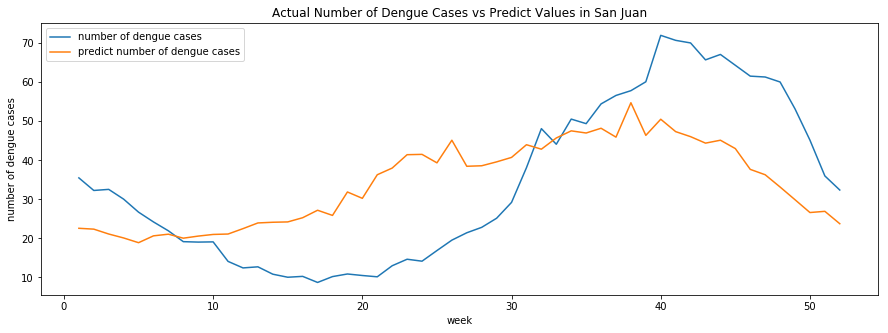

In [38]:
# plot actual and predict number of dengue case in San Juan
actual_sj = new_sj.groupby('new_weekofyear')['dengue_cases'].mean()
predict_sj = new_sj.groupby('new_weekofyear')['pred'].mean()
plt.figure(figsize=(15,5))
plt.plot(list(range(1,53)), actual_sj, label = 'number of dengue cases')
plt.plot(list(range(1,53)), predict_sj, label = 'predict number of dengue cases')
plt.title('Actual Number of Dengue Cases vs Predict Values in San Juan')
plt.xlabel('week')
plt.ylabel('number of dengue cases')
plt.legend()
plt.show()

From the plot we can see that **the model is able to predict the trend of Dengue cases in San Juan**. However, the predict values are larger from week 8 to week 31, and other weeks the predict values are smaller. This shows that our model cannot predict the number of dengue cases well.

### Iquitos Model

The beta coefficients for San Juan model is:

In [39]:
iq_coef

Intercept                                361.254594
reanalysis_specific_humidity_g_per_kg      1.550754
reanalysis_dew_point_temp_k               -1.290621
reanalysis_min_air_temp_k                 -0.009934
station_min_temp_c                         0.122956
reanalysis_tdtr_k                         -0.098830
reanalysis_relative_humidity_percent      -0.042370
station_avg_temp_c                         0.018120
dtype: float64

The formula for Iquitos model is:
$$log(pred) = 361.254594 + 1.550754 * reanalysis_specific_humidity_g_per_kg - 1.290621 * reanalysis_dew_point_temp_k -
0.009934 * reanalysis_min_air_temp_k + 0.122956 * station_min_temp_c - 
0.098830 * reanalysis_tdtr_k - 0.042370 * reanalysis_relative_humidity_percent + 
0.018120 * station_avg_temp_c$$

The beta values for each variable shows the strength of the relationship. For example, `station_avg_temp_c` has the beta value 0.018120, which means that when `station_avg_temp_c` increases by 1, the prediction value will increase by 0.018120.

The plot below shows the comparison of actual number of dengue cases in Iquitos and predict values.

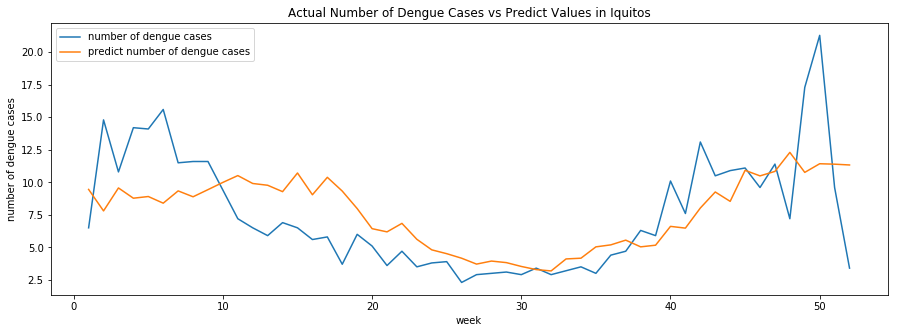

In [40]:
# plot actual and predict number of dengue case in Iquitos
actual_iq = iq.groupby('new_weekofyear')['dengue_cases'].mean()
predict_iq = iq.groupby('new_weekofyear')['pred'].mean()
plt.figure(figsize=(15,5))
plt.plot(list(range(1,53)), actual_iq, label = 'number of dengue cases')
plt.plot(list(range(1,53)), predict_iq, label = 'predict number of dengue cases')
plt.title('Actual Number of Dengue Cases vs Predict Values in Iquitos')
plt.xlabel('week')
plt.ylabel('number of dengue cases')
plt.legend()
plt.show()

From the plot we can see that the model has a good prediction on the number of dengue cases in Iquitos most of the time. There is a outlier in week 50 for the actual dataset, so the predict values have a large difference at that time period. Overall, this model predicts the outcome well.